# Reading Data

In [3]:
import networkx as nx


friends_network = nx.DiGraph()            # PARENT is followed by CHILD
friends_network_reversed = nx.DiGraph()   # PARENT follows CHILD
retweets_network = nx.DiGraph()           # PARENT is retweeted by CHILD
retweets_network_reversed = nx.DiGraph()  # PARENT retweets CHILD

retweets_raw = open("fake_retweet_network.edgelist", "r").read().strip().split("\n")
retweets_data = []
for line in retweets_raw:
    retweets_network.add_edge(int(line.split(" ")[1]), int(line.split(" ")[0]))
    retweets_network_reversed.add_edge(int(line.split(" ")[0]), int(line.split(" ")[1]))

friends_raw = open("fake_social_network.edgelist", "r").read().strip().split("\n")
for line in friends_raw:
  if int(line.split(" ")[1]) in retweets_network.nodes:
    friends_network.add_edge(int(line.split(" ")[1]), int(line.split(" ")[0]))
    friends_network_reversed.add_edge(int(line.split(" ")[0]), int(line.split(" ")[1]))

# Analysis

1.2888655751103149 39.07603171002507


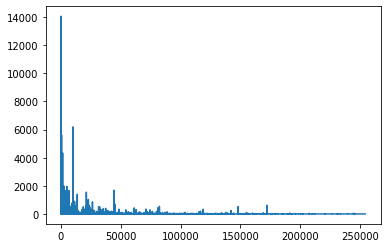

In [4]:
from matplotlib import pyplot as plt
from numpy import std, mean

y = [len(retweets_network.adj[node]) for node in friends_network.nodes if node in retweets_network.nodes]
print(mean(y), std(y))
plt.plot(y)
plt.show()

In [5]:
from random import random

data = []
target = []

for node in friends_network.nodes:
  if node in retweets_network.nodes:
    if len(retweets_network.adj[node]):
      target.append(len(retweets_network.adj[node]) // 5)  # Number of Retweets
    else:
      continue
  else:
    continue

  line = []

  line.append(len(friends_network.adj[node]))     # Number of Followers
  line.append(len(friends_network_reversed.adj[node]))  # Number of Follows

  avg = 0
  for elem in friends_network.adj[node]:
    avg += len(friends_network_reversed.adj[elem]) / len(friends_network.adj[node])
  
  line.append(int(avg))                                # Average Number of Follows of Followers

  avg = 0
  for elem in friends_network.adj[node]:
    if elem in retweets_network_reversed.nodes:
      avg += len(retweets_network_reversed.adj[elem]) / len(friends_network.adj[node])
  
  line.append(int(avg))                                # Average Number of Tweets of Followers

  data.append(line)

Freeing up the RAM

In [6]:
del friends_network
del friends_network_reversed
del retweets_network
del retweets_network_reversed

In [7]:
#Removing outliers
from numpy import mean, std

m = mean(target)
s = std(target)
data1 = []
target1 = []
for i in range(len(target)):
  if target[i] <= m + 2 * s:
    target1.append(target[i])
    data1.append(data[i])

data = data1
target = target1

# Machine Learning

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import max_error, mean_absolute_error, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")


x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

model = RandomForestClassifier(n_estimators=300, class_weight="balanced")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Model Training Accuracy:", model.score(x_train, y_train))
print("Model Testing Accuracy:", model.score(x_test, y_test))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Testing Max Error:", max_error(y_test, y_pred))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Model Training Accuracy: 0.9972329491896494
Model Testing Accuracy: 0.8303332522500608
Mean Absolute Error: 0.6019216735587448
Testing Max Error: 39
F1 Score: 0.7815791382702116
Precision: 0.747385136274709
Recall: 0.8303332522500608


# Deployment

Only run this cell if the cell below fails

In [9]:
import pickle
pickle.dump(model, open("model.sav", "wb"))

In [16]:
#!pip install kedro

In [11]:
from kedro.pipeline import node, Pipeline
from kedro.io import DataCatalog, MemoryDataSet
from kedro.runner import SequentialRunner

model = pickle.load(open("model.sav", "rb"))

In [12]:
def get_input_data():
  return int(input("Number of Followers: ")), int(input("Number of Follows: ")), int(input("Average number of Follows the followers have: ")), int(input("Average number of tweets of the followers : "))

input_data_node = node(func=get_input_data, inputs=None, outputs="input_data")

def model_predict(input_data):
  global model
  print(model.predict([list(input_data)]))
  return model.predict([list(input_data)])[0]

prediction_node = node(func=model_predict, inputs="input_data", outputs="prediction")

def result(prediction):
  return prediction * 5, (prediction + 1) * 5

result_node = node(func=result, inputs="prediction", outputs="result")

In [13]:
pipeline = Pipeline([input_data_node, prediction_node, result_node])
data_catalog = DataCatalog({"input_data": MemoryDataSet(), "prediction": MemoryDataSet(), "result": MemoryDataSet()})

In [14]:
runner = SequentialRunner()
print(runner.run(pipeline, data_catalog))

/usr/local/lib/python3.7/dist-packages/kedro/io/data_catalog.py:194: DeprecationWarning: The transformer API will be deprecated in Kedro 0.18.0.Please use Dataset Hooks to customise the load and save methods.For more information, please visithttps://kedro.readthedocs.io/en/stable/07_extend_kedro/02_hooks.html
  DeprecationWarning,


Number of Followers: 2
Number of Follows: 3
Average number of Follows the followers have: 3
Average number of tweets of the followers : 2
[0]
{}


In [15]:
runner = SequentialRunner()
print(runner.run(pipeline, data_catalog))


/usr/local/lib/python3.7/dist-packages/kedro/io/data_catalog.py:194: DeprecationWarning: The transformer API will be deprecated in Kedro 0.18.0.Please use Dataset Hooks to customise the load and save methods.For more information, please visithttps://kedro.readthedocs.io/en/stable/07_extend_kedro/02_hooks.html
  DeprecationWarning,


Number of Followers: 34567
Number of Follows: 34567
Average number of Follows the followers have: 34567
Average number of tweets of the followers : 34567
[35]
{}
